In [1]:
import numpy as np
import imageio
import h5py

In [2]:
# w,h = 1920,1080
w,h = 1920,1200
w_range = np.arange(2**11)
x,y=np.meshgrid(w_range,w_range)


In [3]:
x_low = (x%256).astype(np.uint8) # 8 bit
x_high = (x//256).astype(np.uint8) # we actualy need only 3 of 8 bit
x_low = np.expand_dims(x_low,-1)
x_high = np.expand_dims(x_high,-1)
x_low_bit = np.unpackbits(x_low,axis=-1)
x_high_bit = np.unpackbits(x_high,axis=-1)
x_bit = np.concatenate([x_high_bit,x_low_bit],axis=-1)

for i in range(11):
    # 3 of high_bit, all(8) of low_bit
    imageio.imsave(f'/root/workspace/DR/data/bkgd/col_{i:02}.png',255*x_bit[:h,:w,5+i])

In [4]:
y_low = (y%256).astype(np.uint8)
y_high = (y//256).astype(np.uint8)
y_low = np.expand_dims(y_low,-1)
y_high = np.expand_dims(y_high,-1)
y_low_bit = np.unpackbits(y_low,axis=-1)
y_high_bit = np.unpackbits(y_high,axis=-1)
y_bit = np.concatenate([y_high_bit,y_low_bit],axis=-1)

for i in range(11):
    imageio.imsave(f'/root/workspace/DR/data/bkgd/row_{i:02}.png',255*y_bit[:h,:w,5+i])

In [5]:
imageio.imsave(f'/root/workspace/DR/data/bkgd/white.png',255*np.ones_like(y_bit[:h,:w,0]))

In [91]:
rec_high = np.packbits(bit[:,:,:8],axis=-1).squeeze()
rec_low = np.packbits(bit[:,:,8:],axis=-1).squeeze()
rec_x = 256*rec_high + rec_low

0

In [24]:
h5data = h5py.File(f'/root/workspace/data/monkey.h5','r')
i=0
out_dir = h5data['ray'][i,:,-3:]
# out_origin = h5data['ray'][i,:,-6:-3]
out_origin = h5data['cleaned_position'][i,:]
mask = h5data['mask'][i][:,:,0]
origin = h5data['ray'][i,:,:3]
ray_dir = h5data['ray'][i,:,3:6]
R_inverse = h5data['cam_proj'][i]
K = h5data['cam_k'][:]
R = np.linalg.inv(R_inverse)
K_inverse = np.linalg.inv(K)


In [45]:
screen_coor = out_origin[out_origin[:,0]>0]

In [53]:
screen_coor

array([[ 2.8957e+01,  1.3514e+02, -1.7354e+02],
       [ 2.7337e+01,  1.3513e+02, -1.7354e+02],
       [ 2.4637e+01,  1.3513e+02, -1.7354e+02],
       ...,
       [ 5.9738e-01,  1.6898e+01, -1.6905e+02],
       [ 8.6738e-01,  1.6899e+01, -1.6905e+02],
       [ 5.7379e-02,  1.6897e+01, -1.6905e+02]])

In [49]:
screen_coor[:,2].max() - screen_coor[:,2].min()

11.049999999999983

In [9]:
screen_P = np.genfromtxt('/root/workspace/data/TransRecon_RealCapturedDate/real/monkey/1/proj.csv', delimiter=',')

In [51]:
screen_P

array([[ 9.99967e-01,  7.24791e-03,  3.68321e-03, -3.53717e+00],
       [ 7.77140e-03, -9.85213e-01, -1.71159e-01, -1.06575e+01],
       [ 2.38820e-03,  1.71182e-01, -9.85236e-01,  7.42027e+02]])

In [42]:
screen_center = R[:3,:3] @ screen_P[:,3:4] + R[:3,3:4]

In [55]:
screen_center

array([[ 9.37963584e-02],
       [ 1.22931215e+02],
       [-1.73074210e+02]])

In [39]:
x_dir = np.array([[1],[0],[0]])
y_dir = np.array([[0],[1],[0]])

x_dir = screen_P[:3,:3] @ x_dir + screen_P[:3,3:4]
y_dir = screen_P[:3,:3] @ y_dir + screen_P[:3,3:4]

x_dir = R[:3,:3] @ x_dir + R[:3,3:4]
y_dir = R[:3,:3] @ y_dir + R[:3,3:4]

In [43]:
x_dir - screen_center

array([[ 9.99997106e-01],
       [ 2.18968981e-03],
       [-3.48469134e-04]])

In [44]:
y_dir - screen_center

array([[-0.00220132],
       [ 0.99928031],
       [-0.03788349]])

In [50]:
h5data['cam_proj'][i]

array([[ 9.99950e-01,  9.57184e-03,  3.05753e-03, -4.27846e+00],
       [ 9.89475e-03, -9.90970e-01, -1.33715e-01,  8.80201e+01],
       [ 1.75002e-03,  1.33739e-01, -9.91015e-01,  5.54067e+02],
       [ 0.00000e+00,  0.00000e+00,  0.00000e+00,  1.00000e+00]])

In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import meshlabxml as mlx
import os
import numpy as np
def mean_hausd(source_path, target_path):
    pid = str(os.getpid())
    logpath = f"/dev/shm/DR/hausd_log_{pid}"
    ssh = "ssh jiahui@172.31.224.138 "
    # cmd = f"DISPLAY=:1 meshlabserver -i  {source_path} {target_path}   -s {paper_path}/hausd.mlx -l " + logpath
    cmd = f"DISPLAY=:1 DR/MeshLabServer2020.04-linux.AppImage -i  DR/show/paper/{source_path} DR/show/paper/{target_path}   -s DR/show/paper/hausd.mlx -l " + logpath
    # assert (os.system(cmd + " 1>/dev/null 2>&1")==0)
    assert (os.system(ssh + cmd + " 1>/dev/null 2>&1")==0)
    dist = mlx.compute.parse_hausdorff(logpath)['mean_distance']
    os.system('rm '+logpath)
    return dist

In [2]:
import torch
Float = torch.float64
device='cuda'
resy=1080
resx=1920
import Render_opencv as Render
Render.resy = resy
Render.resx = resx
Render.device = device
Render.Float = Float

def generate_ray(K_inverse, R_inverse):
    y_range = torch.arange(0, resy, device=device, dtype=Float)
    x_range = torch.arange(0, resx, device=device, dtype=Float)
    pixely, pixelx = torch.meshgrid(y_range, x_range)
    pixelz = torch.ones_like(pixely)
    pixel = torch.stack([pixelx, pixely, pixelz], dim=2).view([-1,3])
    pixel_p = K_inverse @ pixel.T
    
    pixel_world_p  = R_inverse[:3,:3] @ pixel_p + R_inverse[:3, 3:4]
    ray_origin = R_inverse[:3, 3:4] #[3x1]
    ray_dir = pixel_world_p - ray_origin
    ray_dir = ray_dir.T #[nx3]
    ray_dir = ray_dir/ray_dir.norm(dim=1,keepdim=True)
    ray_origin = ray_origin.T.expand_as(ray_dir)
    return ray_origin, ray_dir

def get_view(name):
    Views = []
    h5data = h5py.File(f'/root/workspace/data/{name}.h5','r')
    for i in range(72):
        out_origin = h5data['cleaned_position'][i,:].reshape([-1,3])
        mask = h5data['mask'][i]
        R = h5data['cam_proj'][i]
        K = h5data['cam_k'][:]
        R_inverse = np.linalg.inv(R)
        K_inverse = np.linalg.inv(K)

        if len(mask.shape) == 3: mask = mask[...,0]
        if len(out_origin.shape) == 3: out_origin = out_origin.reshape(-1,3)

        out_origin = torch.tensor(out_origin, dtype=Float, device=device)
        mask = torch.tensor(mask, dtype=Float, device=device)
        R = torch.tensor(R, dtype=Float, device=device)
        K = torch.tensor(K, dtype=Float, device=device)
        R_inverse = torch.tensor(R_inverse, dtype=Float, device=device)
        K_inverse = torch.tensor(K_inverse, dtype=Float, device=device)
        valid = out_origin[:,0] != 0
        camera_M = (R, K, R_inverse, K_inverse)
        Views.append((out_origin, valid, mask, camera_M))
    return Views

def get_view_torch(Views,V_index):
    out_origin, valid, mask, camera_M = Views[V_index]
    R, K, R_inverse, K_inverse = camera_M
    origin, ray_dir = generate_ray(K_inverse, R_inverse)
    ####################################################
    #exchange  R_inverse and R name 
    # camera_M = (R, K, R_inverse, K_inverse)
    camera_M = (R_inverse, K, R, K_inverse)
    ######################################################
    return out_origin, valid, mask, origin, ray_dir, camera_M


In [3]:
models = ['dog', 'monkey','horse','rabbit_new','tiger','pig','mouse','hand']
# models = ['horse','rabbit_new','tiger','pig']
valid_rate = []
for name in models:
    Views = get_view(name)
    scene = Render.Scene(f"/root/workspace/show/paper/{name}/result.obj")
    # scene = Render.Scene(f"/root/workspace/show/paper/{name}_scan.OBJ")
    sum = 0
    for V_index in range(72):
        out_origin, valid, mask, origin, ray_dir, camera_M = get_view_torch(Views, V_index)
        render_out_ori, render_out_dir, render_mask = scene.render_transparent(origin, ray_dir)
        render_mask = render_mask[:,0]
        mesh_mask = scene.render_mask(origin, ray_dir)
        sum += render_mask.sum() / mesh_mask.sum()
    valid_rate.append(sum/72)


RuntimeError: CUDA out of memory. Tried to allocate 48.00 MiB (GPU 0; 11.91 GiB total capacity; 7.32 GiB already allocated; 45.12 MiB free; 7.51 GiB reserved in total by PyTorch)

In [8]:
valid_rate

[tensor(0.5645, device='cuda:0', dtype=torch.float64),
 tensor(0.5540, device='cuda:0', dtype=torch.float64),
 tensor(0.5581, device='cuda:0', dtype=torch.float64),
 tensor(0.4777, device='cuda:0', dtype=torch.float64),
 tensor(0.5129, device='cuda:0', dtype=torch.float64),
 tensor(0.5203, device='cuda:0', dtype=torch.float64),
 tensor(0.4462, device='cuda:0', dtype=torch.float64),
 tensor(0.5407, device='cuda:0', dtype=torch.float64)]

In [3]:
error = [0.002065,
# 0.002696,
0.002244,
0.00116001,
0.00284755,
0.00301998,
0.00269581,
0.003075,
0.00234
]

In [ ]:
# models = ['dog', 'monkey','horse','rabbit_new','tiger','pig','mouse']
# error = []
# for name in models:
#     target_path = f'{name}_scan.OBJ'
#     source_path = f'{name}/result.obj'
#     error.append(mean_hausd(source_path, target_path))

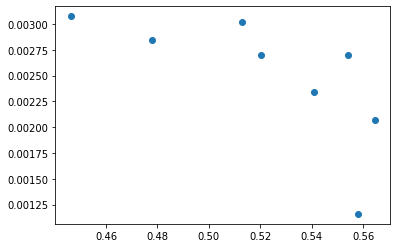

In [15]:
plt.plot(valid_rate,error,'o')
# plt.xticks(models) 

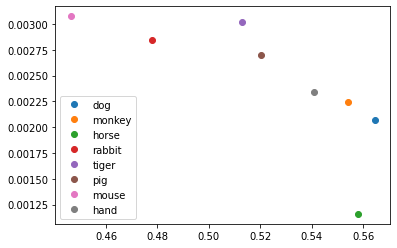

In [12]:
for i in range(len(models)):
    plt.plot(valid_rate[i:i+1],error[i:i+1],'o')
plt.legend(labels=['dog', 'monkey','horse','rabbit','tiger','pig','mouse','hand'],loc='best')
plt.savefig(f'analysis.pdf')  